# Training and Predicting Optimal Makespan with Lenet-5 Mockup model with uncertainty
## On Q Instances
The notebook will be performing prediction of the optimal makespan.

The output of this model should be a pandas dataframe where:
- each row represent a single JSSP instances 
- each row contains information about ``name`` and ``predicted optimal makespan`` of the instance

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import load_model

In [2]:
import os
import tensorflow as tf
# Specify which GPU(s) to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Or 2, 3, etc. other than 0

# On CPU/GPU placement
config = tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=True)
config.gpu_options.allow_growth = True
tf.compat.v1.Session(config=config)

# Note that ConfigProto disappeared in TF-2.0

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



In [3]:
print(tf.__version__)

2.3.0


In [4]:
RND_SEED = 42

In [5]:
np.random.seed(RND_SEED)

In [6]:
from utils.JsspInstanceParser import get_instance_dict

In [7]:
def combine_the_data(pickle_file, instance_file="../job-shop/job-shop-instances.hpp", truncate=1.0):
    benchmark_result_df = pd.read_pickle(pickle_file)
    print("total log num = ", len(benchmark_result_df))
    if truncate > -1.0 and truncate <0:
        benchmark_result_df = benchmark_result_df[int(len(benchmark_result_df)*abs(truncate)):]
    elif truncate < 1.0:
        benchmark_result_df = benchmark_result_df[:int(len(benchmark_result_df)*truncate)]
    elif truncate > 1.0:
        benchmark_result_df = benchmark_result_df[:int(truncate)]
    # prepare numerical input data
    input_name_list = list(benchmark_result_df.columns.values)
    input_name_list.remove('runtime_ms')
    input_name_list.remove('probing_time_ms')
    input_name_list.remove('adjusting_time_ms')
    input_name_list.remove('solving_time_ms')
    input_name_list.remove('makespan')
    input_name_list.remove('Instance')
    input_name_list.remove('Heuristic')
    print("The numerical input data   are {}".format(input_name_list))

    input_data = benchmark_result_df[input_name_list]
    X_numeric = input_data.to_numpy()

    # perform one hot encoding on 'Heuristic'
    enc = OneHotEncoder()
    enc.fit(benchmark_result_df[['Heuristic']])
    X_onehot = enc.transform(benchmark_result_df[['Heuristic']]).toarray()

    # get the instance array 
    input_instance_name_list = benchmark_result_df['Instance'].to_numpy()
    instance_dict = get_instance_dict(instance_file)
    input_instance_array_list = [instance_dict[name]['instance_array'].reshape(instance_dict[name]['num_of_jobs'],-1) for name in input_instance_name_list]
    X_instance = np.array(input_instance_array_list)
    X_instance = np.expand_dims(X_instance, axis=-1)
    # insanity check
    for ind, val in enumerate(input_instance_array_list):
        assert np.array_equal(X_instance[ind], np.expand_dims(val, axis=-1))
    print("The shape of the instance array is {}".format(X_instance.shape))
    
    X_instance_name_list = benchmark_result_df[['Instance']]
    
    
    # merge the input data together
    assert X_numeric.shape[0] == X_onehot.shape[0], "Shape must be the same"
    X = np.hstack((X_numeric, X_onehot))
    print("The shape of the input data is : ", X.shape)

    # prepare the output data
    y_makespan = benchmark_result_df['makespan'].to_numpy().reshape(-1, 1)
    y_makespan = y_makespan.astype(np.dtype('int32'))
    print("The shape of the output data (makespan) is : ", y_makespan.shape)

    y_runtime = benchmark_result_df['runtime_ms'].to_numpy().reshape(-1, 1)
    y_runtime = y_runtime.astype(np.dtype('int32'))
    print("The shape of the output data (runtime) is : ", y_runtime.shape)
    
    return X, X_instance, X_instance_name_list, y_makespan, y_runtime

In [8]:
X, X_instance, X_instance_name_list, y_makespan, y_runtime = combine_the_data('./DL-Q10000_dataset/benchmark_result_df_DL_Q10000.pkl', truncate=1.0)

total log num =  10000
The numerical input data   are ['tbf', 'first_LB', 'first_UB', 'first_makespan', 'probing_progress', 'num_of_jobs', 'num_of_machines', 'max_operation_time', 'max_machine_load', 'r_first_makespan_bound']
Finish parsing 31162 jssp instances.
The shape of the instance array is (10000, 9, 18, 1)
The shape of the input data is :  (10000, 11)
The shape of the output data (makespan) is :  (10000, 1)
The shape of the output data (runtime) is :  (10000, 1)


In [9]:
X_train, X_test, X_instance_train, X_instance_test, X_instance_name_list_train, X_instance_name_list_test, y_makespan_train, y_makespan_test, y_runtime_train, y_runtime_test = train_test_split(X, X_instance, X_instance_name_list, y_makespan, y_runtime, test_size=0.4, shuffle=True, random_state=RND_SEED)

print("The shape of X_train \t\t is {}".format(X_train.shape))
print("The shape of X_test \t\t is {}".format(X_test.shape))
print("The shape of X_instance_train \t is {}".format(X_instance_train.shape))
print("The shape of X_instance_test \t is {}".format(X_instance_test.shape))
print("The shape of y_makespan_train \t is {}".format(y_makespan_train.shape))
print("The shape of y_makespan_test \t is {}".format(y_makespan_test.shape))
print("The shape of y_runtime_train \t is {}".format(y_runtime_train.shape))
print("The shape of y_runtime_test \t is {}".format(y_runtime_test.shape))

# X_scaled = StandardScaler().fit_transform(X[:, 1:],)
X_std_scaler = StandardScaler()
X_std_scaler.fit(X_train)
X_train_scaled = X_std_scaler.transform(X_train)
X_test_scaled = X_std_scaler.transform(X_test)

instance_train_shape = X_instance_train.shape
instance_test_shape = X_instance_test.shape

X_instance_scaler = MinMaxScaler()
X_instance_scaler.fit(X_instance_train.reshape(-1,1))
X_instance_train_scaled = X_instance_scaler.transform(X_instance_train.reshape(-1,1)).reshape(instance_train_shape)
X_instance_test_scaled = X_instance_scaler.transform(X_instance_test.reshape(-1,1)).reshape(instance_test_shape)
# reform into channel
X_instance_train_scaled_2channel = np.concatenate((X_instance_train_scaled[:, :, 0::2], X_instance_train_scaled[:, :, 1::2]), axis = 3)
X_instance_test_scaled_2channel = np.concatenate((X_instance_test_scaled[:, :, 0::2], X_instance_test_scaled[:, :, 1::2]), axis = 3)

print("The shape of X_instance_train_scaled_2channel \t\t is {}".format(X_instance_train_scaled_2channel.shape))
print("The shape of X_instance_test_scaled_2channel \t\t is {}".format(X_instance_test_scaled_2channel.shape))

The shape of X_train 		 is (6000, 11)
The shape of X_test 		 is (4000, 11)
The shape of X_instance_train 	 is (6000, 9, 18, 1)
The shape of X_instance_test 	 is (4000, 9, 18, 1)
The shape of y_makespan_train 	 is (6000, 1)
The shape of y_makespan_test 	 is (4000, 1)
The shape of y_runtime_train 	 is (6000, 1)
The shape of y_runtime_test 	 is (4000, 1)
The shape of X_instance_train_scaled_2channel 		 is (6000, 9, 9, 2)
The shape of X_instance_test_scaled_2channel 		 is (4000, 9, 9, 2)


## Train the model

In [10]:
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, DepthwiseConv2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [11]:
X_instance_input_shape = tuple(list(X_instance_train_scaled_2channel.shape)[1:])
# aux_input_shape = X_instance_train_scaled.shape

X_instance_input = Input(shape=X_instance_input_shape, name='JSSP_instance_input')

X_instance = Conv2D(6, kernel_size=3, strides=(1,1), padding='valid', data_format='channels_last', activation='tanh')(X_instance_input)
X_instance = DepthwiseConv2D(1, data_format='channels_last',activation='tanh')(X_instance)

X_instance = Conv2D(16, kernel_size=3, strides=(1,1), padding='valid', data_format='channels_last', activation='tanh')(X_instance)
X_instance = DepthwiseConv2D(1, data_format='channels_last',activation='tanh')(X_instance)


X_instance = Conv2D(120, kernel_size=3, strides=(1,1), padding='valid', data_format='channels_last', activation='tanh')(X_instance)
# X_instance = DepthwiseConv2D(1, data_format='channels_last',activation='tanh')(X_instance)


X_instance = Flatten()(X_instance)

# X_instance = Dense(32, activation='relu')(X_instance)
# X_instance = Dropout(0.2)(X_instance, training=True)
X_instance = Dense(32, activation='relu')(X_instance)
X_instance = Dropout(0.1)(X_instance, training=True)
X_instance = Dense(16, activation='relu')(X_instance)
y = Dense(1)(X_instance)

In [12]:
makespan_instance_only_model = Model(inputs=[X_instance_input], outputs=[y])
makespan_instance_only_model.compile(optimizer='adam', loss='mse')
makespan_instance_only_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
JSSP_instance_input (InputLa [(None, 9, 9, 2)]         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 6)           114       
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 7, 7, 6)           12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 16)          880       
_________________________________________________________________
depthwise_conv2d_1 (Depthwis (None, 5, 5, 16)          32        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 120)         17400     
_________________________________________________________________
flatten (Flatten)            (None, 1080)             

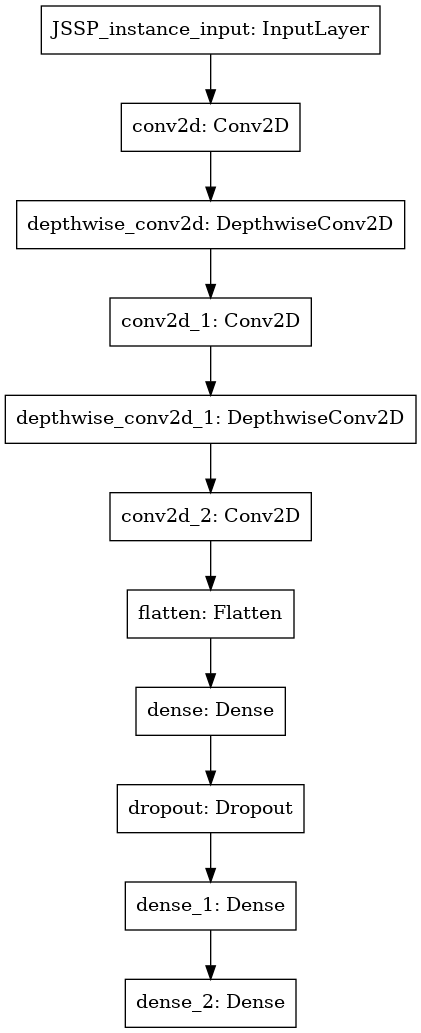

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(makespan_instance_only_model, to_file='model.png')

In [14]:
FOLDER = "./model/"
TB_LOG_DIR = FOLDER + "tf_logs/"

MODEL_DIR = FOLDER + "model_checkpoint/"

GENERAL_MODEL_NAME = "makespan_instance_only_Q_"

tb_makespan_instance_only = TensorBoard(log_dir=TB_LOG_DIR)

In [15]:
model_batch_size = 100
VALIDATION_SPLIT = 1/6

In [16]:
init_epoch = 0
end_epoch = 100

In [17]:
%time makespan_instance_only_model.fit([X_instance_train_scaled_2channel], [y_makespan_train], epochs=end_epoch, batch_size=model_batch_size, validation_split=VALIDATION_SPLIT, callbacks=[tb_makespan_instance_only], initial_epoch=init_epoch)

Epoch 1/100
 1/50 [..............................] - ETA: 0s - loss: 542281.7500WARNING:tensorflow:From /home/bw/.local/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
50/50 [==============================] - 0s 10ms/step - loss: 421684.9375 - val_loss: 118509.3828
Epoch 2/100
50/50 [==============================] - 0s 7ms/step - loss: 24810.5117 - val_loss: 6968.7334
Epoch 3/100
50/50 [==============================] - 0s 7ms/step - loss: 7006.5815 - val_loss: 6934.3335
Epoch 4/100
50/50 [==============================] - 0s 7ms/step - loss: 7184.6782 - val_loss: 6485.8877
Epoch 5/100
50/50 [==============================] - 0s 7ms/step - loss: 7067.5488 - val_loss: 6779.7910
Epoch 6/100
50/50 [==============================] - 0s 7ms/step - loss: 6917.3208 - val_loss: 6369.1582
Epoch 7/100
5

In [18]:
%time makespan_instance_only_test_loss = makespan_instance_only_model.evaluate(x=[X_instance_test_scaled_2channel], y=[y_makespan_test], batch_size=model_batch_size)
print("Loss on test set is {}".format(makespan_instance_only_test_loss))
makespan_instance_only_model.save(MODEL_DIR + GENERAL_MODEL_NAME + str(end_epoch) + '.h5')

40/40 [==============================] - 0s 3ms/step - loss: 5656.4858
CPU times: user 367 ms, sys: 71.8 ms, total: 439 ms
Wall time: 164 ms
Loss on test set is 5656.48583984375


In [19]:
init_epoch = 100
end_epoch = 200

In [20]:
%time makespan_instance_only_model.fit([X_instance_train_scaled_2channel], [y_makespan_train], epochs=end_epoch, batch_size=model_batch_size, validation_split=VALIDATION_SPLIT, callbacks=[tb_makespan_instance_only], initial_epoch=init_epoch)

Epoch 101/200
50/50 [==============================] - 0s 7ms/step - loss: 5082.6787 - val_loss: 4924.7681
Epoch 102/200
50/50 [==============================] - 0s 7ms/step - loss: 4974.4346 - val_loss: 4824.4121
Epoch 103/200
50/50 [==============================] - 0s 7ms/step - loss: 4951.0640 - val_loss: 4633.0225
Epoch 104/200
50/50 [==============================] - 0s 7ms/step - loss: 4944.6040 - val_loss: 4708.9692
Epoch 105/200
50/50 [==============================] - 0s 7ms/step - loss: 5186.7993 - val_loss: 4591.9585
Epoch 106/200
50/50 [==============================] - 0s 7ms/step - loss: 5109.4272 - val_loss: 4383.8613
Epoch 107/200
50/50 [==============================] - 0s 7ms/step - loss: 4944.4658 - val_loss: 4469.4502
Epoch 108/200
50/50 [==============================] - 0s 7ms/step - loss: 4892.7090 - val_loss: 4508.0386
Epoch 109/200
50/50 [==============================] - 0s 7ms/step - loss: 4935.9517 - val_loss: 4594.1992
Epoch 110/200
50/50 [================

In [21]:
%time makespan_instance_only_test_loss = makespan_instance_only_model.evaluate(x=[X_instance_test_scaled_2channel], y=[y_makespan_test], batch_size=model_batch_size)
print("Loss on test set is {}".format(makespan_instance_only_test_loss))
makespan_instance_only_model.save(MODEL_DIR + GENERAL_MODEL_NAME + str(end_epoch) + '.h5')

40/40 [==============================] - 0s 3ms/step - loss: 4863.3916
CPU times: user 343 ms, sys: 88.8 ms, total: 432 ms
Wall time: 166 ms
Loss on test set is 4863.3916015625


In [22]:
init_epoch = 200
end_epoch = 300

In [23]:
%time makespan_instance_only_model.fit([X_instance_train_scaled_2channel], [y_makespan_train], epochs=end_epoch, batch_size=model_batch_size, validation_split=VALIDATION_SPLIT, callbacks=[tb_makespan_instance_only], initial_epoch=init_epoch)

Epoch 201/300
50/50 [==============================] - 0s 7ms/step - loss: 4701.4116 - val_loss: 4781.4409
Epoch 202/300
50/50 [==============================] - 0s 7ms/step - loss: 4667.5518 - val_loss: 4295.7710
Epoch 203/300
50/50 [==============================] - 0s 7ms/step - loss: 4650.1162 - val_loss: 4858.1787
Epoch 204/300
50/50 [==============================] - 0s 7ms/step - loss: 4928.2593 - val_loss: 4941.8257
Epoch 205/300
50/50 [==============================] - 0s 7ms/step - loss: 4822.5493 - val_loss: 4406.8872
Epoch 206/300
50/50 [==============================] - 0s 7ms/step - loss: 4648.9150 - val_loss: 4295.5913
Epoch 207/300
50/50 [==============================] - 0s 7ms/step - loss: 4714.5142 - val_loss: 4297.4517
Epoch 208/300
50/50 [==============================] - 0s 7ms/step - loss: 4943.8643 - val_loss: 4967.3926
Epoch 209/300
50/50 [==============================] - 0s 7ms/step - loss: 4900.6509 - val_loss: 4229.6768
Epoch 210/300
50/50 [================

In [24]:
%time makespan_instance_only_test_loss = makespan_instance_only_model.evaluate(x=[X_instance_test_scaled_2channel], y=[y_makespan_test], batch_size=model_batch_size)
print("Loss on test set is {}".format(makespan_instance_only_test_loss))
makespan_instance_only_model.save(MODEL_DIR + GENERAL_MODEL_NAME + str(end_epoch) + '.h5')

40/40 [==============================] - 0s 3ms/step - loss: 4474.8169
CPU times: user 391 ms, sys: 32 ms, total: 423 ms
Wall time: 163 ms
Loss on test set is 4474.81689453125


In [25]:
init_epoch = 300
end_epoch = 400

In [26]:
%time makespan_instance_only_model.fit([X_instance_train_scaled_2channel], [y_makespan_train], epochs=end_epoch, batch_size=model_batch_size, validation_split=VALIDATION_SPLIT, callbacks=[tb_makespan_instance_only], initial_epoch=init_epoch)

Epoch 301/400
50/50 [==============================] - 0s 7ms/step - loss: 4735.5820 - val_loss: 4734.4980
Epoch 302/400
50/50 [==============================] - 0s 7ms/step - loss: 4698.3179 - val_loss: 5041.9863
Epoch 303/400
50/50 [==============================] - 0s 7ms/step - loss: 4562.2974 - val_loss: 4485.3628
Epoch 304/400
50/50 [==============================] - 0s 7ms/step - loss: 4680.1074 - val_loss: 4498.4155
Epoch 305/400
50/50 [==============================] - 0s 7ms/step - loss: 4669.3765 - val_loss: 4723.1074
Epoch 306/400
50/50 [==============================] - 0s 7ms/step - loss: 4748.7671 - val_loss: 4216.4663
Epoch 307/400
50/50 [==============================] - 0s 7ms/step - loss: 4611.6768 - val_loss: 4652.1509
Epoch 308/400
50/50 [==============================] - 0s 7ms/step - loss: 4554.4458 - val_loss: 4483.1523
Epoch 309/400
50/50 [==============================] - 0s 7ms/step - loss: 4576.5210 - val_loss: 4264.0547
Epoch 310/400
50/50 [================

In [27]:
%time makespan_instance_only_test_loss = makespan_instance_only_model.evaluate(x=[X_instance_test_scaled_2channel], y=[y_makespan_test], batch_size=model_batch_size)
print("Loss on test set is {}".format(makespan_instance_only_test_loss))
makespan_instance_only_model.save(MODEL_DIR + GENERAL_MODEL_NAME + str(end_epoch) + '.h5')

40/40 [==============================] - 0s 3ms/step - loss: 4821.2236
CPU times: user 406 ms, sys: 17 ms, total: 423 ms
Wall time: 162 ms
Loss on test set is 4821.2236328125


In [28]:
init_epoch = 400
end_epoch = 500

In [29]:
%time makespan_instance_only_model.fit([X_instance_train_scaled_2channel], [y_makespan_train], epochs=end_epoch, batch_size=model_batch_size, validation_split=VALIDATION_SPLIT, callbacks=[tb_makespan_instance_only], initial_epoch=init_epoch)

Epoch 401/500
50/50 [==============================] - 0s 7ms/step - loss: 4486.6138 - val_loss: 4340.1743
Epoch 402/500
50/50 [==============================] - 0s 7ms/step - loss: 4387.2104 - val_loss: 3958.3069
Epoch 403/500
50/50 [==============================] - 0s 7ms/step - loss: 4572.6030 - val_loss: 4350.5430
Epoch 404/500
50/50 [==============================] - 0s 7ms/step - loss: 4517.5039 - val_loss: 4069.2334
Epoch 405/500
50/50 [==============================] - 0s 7ms/step - loss: 4416.0962 - val_loss: 4460.4331
Epoch 406/500
50/50 [==============================] - 0s 7ms/step - loss: 4576.9482 - val_loss: 4636.7266
Epoch 407/500
50/50 [==============================] - 0s 7ms/step - loss: 4481.1802 - val_loss: 4212.2412
Epoch 408/500
50/50 [==============================] - 0s 7ms/step - loss: 4440.7563 - val_loss: 4262.4448
Epoch 409/500
50/50 [==============================] - 0s 7ms/step - loss: 4455.5474 - val_loss: 4316.3184
Epoch 410/500
50/50 [================

In [30]:
%time makespan_instance_only_test_loss = makespan_instance_only_model.evaluate(x=[X_instance_test_scaled_2channel], y=[y_makespan_test], batch_size=model_batch_size)
print("Loss on test set is {}".format(makespan_instance_only_test_loss))
makespan_instance_only_model.save(MODEL_DIR + GENERAL_MODEL_NAME + str(end_epoch) + '.h5')

40/40 [==============================] - 0s 3ms/step - loss: 4243.1714
CPU times: user 282 ms, sys: 127 ms, total: 408 ms
Wall time: 159 ms
Loss on test set is 4243.17138671875


In [31]:
init_epoch = 500
end_epoch = 600

In [32]:
%time makespan_instance_only_model.fit([X_instance_train_scaled_2channel], [y_makespan_train], epochs=end_epoch, batch_size=model_batch_size, validation_split=VALIDATION_SPLIT, callbacks=[tb_makespan_instance_only], initial_epoch=init_epoch)

Epoch 501/600
50/50 [==============================] - 0s 7ms/step - loss: 4202.0718 - val_loss: 3842.5085
Epoch 502/600
50/50 [==============================] - 0s 7ms/step - loss: 4353.2588 - val_loss: 4176.5288
Epoch 503/600
50/50 [==============================] - 0s 7ms/step - loss: 4239.9233 - val_loss: 3873.7229
Epoch 504/600
50/50 [==============================] - 0s 7ms/step - loss: 4219.6460 - val_loss: 3805.7842
Epoch 505/600
50/50 [==============================] - 0s 7ms/step - loss: 4234.0078 - val_loss: 4210.3750
Epoch 506/600
50/50 [==============================] - 0s 7ms/step - loss: 4369.3130 - val_loss: 4350.6616
Epoch 507/600
50/50 [==============================] - 0s 7ms/step - loss: 4354.1450 - val_loss: 3933.4714
Epoch 508/600
50/50 [==============================] - 0s 7ms/step - loss: 4376.8403 - val_loss: 3936.0693
Epoch 509/600
50/50 [==============================] - 0s 7ms/step - loss: 4379.7266 - val_loss: 4108.9980
Epoch 510/600
50/50 [================

In [33]:
%time makespan_instance_only_test_loss = makespan_instance_only_model.evaluate(x=[X_instance_test_scaled_2channel], y=[y_makespan_test], batch_size=model_batch_size)
print("Loss on test set is {}".format(makespan_instance_only_test_loss))
makespan_instance_only_model.save(MODEL_DIR + GENERAL_MODEL_NAME + str(end_epoch) + '.h5')

40/40 [==============================] - 0s 3ms/step - loss: 4139.9507
CPU times: user 345 ms, sys: 62.9 ms, total: 408 ms
Wall time: 153 ms
Loss on test set is 4139.95068359375


In [34]:
init_epoch = 600
end_epoch = 700

In [35]:
%time makespan_instance_only_model.fit([X_instance_train_scaled_2channel], [y_makespan_train], epochs=end_epoch, batch_size=model_batch_size, validation_split=VALIDATION_SPLIT, callbacks=[tb_makespan_instance_only], initial_epoch=init_epoch)

Epoch 601/700
50/50 [==============================] - 0s 7ms/step - loss: 4130.3638 - val_loss: 4387.2920
Epoch 602/700
50/50 [==============================] - 0s 7ms/step - loss: 3834.8804 - val_loss: 3811.3467
Epoch 603/700
50/50 [==============================] - 0s 7ms/step - loss: 4128.6289 - val_loss: 4254.9844
Epoch 604/700
50/50 [==============================] - 0s 7ms/step - loss: 3942.4805 - val_loss: 4050.6550
Epoch 605/700
50/50 [==============================] - 0s 7ms/step - loss: 4124.9419 - val_loss: 3782.1787
Epoch 606/700
50/50 [==============================] - 0s 7ms/step - loss: 3979.6240 - val_loss: 3878.4233
Epoch 607/700
50/50 [==============================] - 0s 7ms/step - loss: 4222.5732 - val_loss: 3909.2107
Epoch 608/700
50/50 [==============================] - 0s 7ms/step - loss: 3998.5359 - val_loss: 3894.3721
Epoch 609/700
50/50 [==============================] - 0s 7ms/step - loss: 4039.8635 - val_loss: 3656.9109
Epoch 610/700
50/50 [================

In [36]:
%time makespan_instance_only_test_loss = makespan_instance_only_model.evaluate(x=[X_instance_test_scaled_2channel], y=[y_makespan_test], batch_size=model_batch_size)
print("Loss on test set is {}".format(makespan_instance_only_test_loss))
makespan_instance_only_model.save(MODEL_DIR + GENERAL_MODEL_NAME + str(end_epoch) + '.h5')

40/40 [==============================] - 0s 3ms/step - loss: 3642.1270
CPU times: user 283 ms, sys: 125 ms, total: 408 ms
Wall time: 155 ms
Loss on test set is 3642.126953125


In [37]:
init_epoch = 800
end_epoch = 900

In [38]:
%time makespan_instance_only_model.fit([X_instance_train_scaled_2channel], [y_makespan_train], epochs=end_epoch, batch_size=model_batch_size, validation_split=VALIDATION_SPLIT, callbacks=[tb_makespan_instance_only], initial_epoch=init_epoch)

Epoch 801/900
50/50 [==============================] - 0s 7ms/step - loss: 3772.2688 - val_loss: 3742.3562
Epoch 802/900
50/50 [==============================] - 0s 7ms/step - loss: 3554.7063 - val_loss: 3674.4082
Epoch 803/900
50/50 [==============================] - 0s 7ms/step - loss: 3727.4299 - val_loss: 3514.7737
Epoch 804/900
50/50 [==============================] - 0s 7ms/step - loss: 3766.7612 - val_loss: 4163.7593
Epoch 805/900
50/50 [==============================] - 0s 7ms/step - loss: 3740.4585 - val_loss: 3952.5059
Epoch 806/900
50/50 [==============================] - 0s 7ms/step - loss: 3704.2412 - val_loss: 3481.2461
Epoch 807/900
50/50 [==============================] - 0s 7ms/step - loss: 3680.5747 - val_loss: 3344.5061
Epoch 808/900
50/50 [==============================] - 0s 7ms/step - loss: 3890.0259 - val_loss: 3177.8538
Epoch 809/900
50/50 [==============================] - 0s 6ms/step - loss: 3750.0615 - val_loss: 3482.0693
Epoch 810/900
50/50 [================

In [39]:
%time makespan_instance_only_test_loss = makespan_instance_only_model.evaluate(x=[X_instance_test_scaled_2channel], y=[y_makespan_test], batch_size=model_batch_size)
print("Loss on test set is {}".format(makespan_instance_only_test_loss))
makespan_instance_only_model.save(MODEL_DIR + GENERAL_MODEL_NAME + str(end_epoch) + '.h5')

40/40 [==============================] - 0s 3ms/step - loss: 3239.6860
CPU times: user 300 ms, sys: 109 ms, total: 409 ms
Wall time: 154 ms
Loss on test set is 3239.68603515625


In [40]:
init_epoch = 900
end_epoch = 1000

In [41]:
%time makespan_instance_only_model.fit([X_instance_train_scaled_2channel], [y_makespan_train], epochs=end_epoch, batch_size=model_batch_size, validation_split=VALIDATION_SPLIT, callbacks=[tb_makespan_instance_only], initial_epoch=init_epoch)

Epoch 901/1000
50/50 [==============================] - 0s 7ms/step - loss: 3410.3423 - val_loss: 3161.3672
Epoch 902/1000
50/50 [==============================] - 0s 7ms/step - loss: 3280.7227 - val_loss: 3897.3938
Epoch 903/1000
50/50 [==============================] - 0s 7ms/step - loss: 3199.6509 - val_loss: 3182.2837
Epoch 904/1000
50/50 [==============================] - 0s 7ms/step - loss: 3282.1355 - val_loss: 3157.0581
Epoch 905/1000
50/50 [==============================] - 0s 7ms/step - loss: 3269.2393 - val_loss: 3327.8677
Epoch 906/1000
50/50 [==============================] - 0s 7ms/step - loss: 3325.1345 - val_loss: 3236.0139
Epoch 907/1000
50/50 [==============================] - 0s 7ms/step - loss: 3460.5056 - val_loss: 3000.6873
Epoch 908/1000
50/50 [==============================] - 0s 7ms/step - loss: 3264.1501 - val_loss: 3107.2385
Epoch 909/1000
50/50 [==============================] - 0s 7ms/step - loss: 3269.7417 - val_loss: 3404.6392
Epoch 910/1000
50/50 [======

In [42]:
%time makespan_instance_only_test_loss = makespan_instance_only_model.evaluate(x=[X_instance_test_scaled_2channel], y=[y_makespan_test], batch_size=model_batch_size)
print("Loss on test set is {}".format(makespan_instance_only_test_loss))
makespan_instance_only_model.save(MODEL_DIR + GENERAL_MODEL_NAME + str(end_epoch) + '.h5')

40/40 [==============================] - 0s 3ms/step - loss: 3004.7800
CPU times: user 348 ms, sys: 63.4 ms, total: 411 ms
Wall time: 154 ms
Loss on test set is 3004.780029296875


## Use the model for predicting

Looking through the loss for train and validation, it seems that the model begins to overfit after 600 epochs of training. So, we decide to use the model after 6000 epochs of training.

In [46]:
from tensorflow.keras.models import load_model

FOLDER = './model/'
model_batch_size = 100

my_model = load_model(FOLDER + 'model_checkpoint/makespan_instance_only_Q_600.h5')

In [47]:
%time a = my_model.predict(x=[X_instance_test_scaled_2channel], batch_size=model_batch_size)

CPU times: user 462 ms, sys: 16.5 ms, total: 479 ms
Wall time: 236 ms


In [48]:
import timeit

start = timeit.timeit()

for i in range(999):
    a = np.concatenate((a, my_model.predict(x=[X_instance_test_scaled_2channel], batch_size=model_batch_size)), axis=1)

end = timeit.timeit()
print(end - start)

-0.0006423000013455749


In [50]:
benchmark_to_test = X_instance_name_list_test.copy()
benchmark_to_test['pred_makespan'] = a.tolist()
benchmark_to_test['true_makespan'] = y_makespan_test

In [51]:
benchmark_to_test.head(5)

,Instance,pred_makespan,true_makespan
6252,q6252,"[776.649658203125, 820.9853515625, 732.4948730...",705
4684,q4684,"[693.7030639648438, 824.7876586914062, 736.686...",786
1731,q1731,"[656.3553466796875, 783.6185913085938, 700.319...",741
4742,q4742,"[674.0472412109375, 639.7532958984375, 673.131...",698
4521,q4521,"[781.022705078125, 736.7913208007812, 736.5009...",731


In [52]:
benchmark_to_test.to_pickle(FOLDER + "benchmark_to_test_with_uncertainty.pkl")

## The END